In [ ]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torch

def generate_poisson_problem(u_func, k = 3, m = 4):
    """Генерирует f(x, y) и g(x, y) для заданного аналитического решения u(x, y)"""
    def laplacian_u(xy):
        x, y = xy[:, 0:1], xy[:, 1:2]
        u_xx = -k**2 * torch.sin(k * x) * torch.cos(m * y)
        u_yy = -m**2 * torch.sin(k * x) * torch.cos(m * y)
        return -(u_xx + u_yy)
    
    
    f = laplacian_u
    g = lambda xy: u_func(xy[:, 0:1], xy[:, 1:2])
    return f, g

def train_pinn(f, g, limits, N_it=10000, num_domain=5000, num_boundary=1000, save_animation = False):
    
    def poisson_residual(x, u):
        du_xx = dde.grad.hessian(u, x, i=0, j=0)
        du_yy = dde.grad.hessian(u, x, i=1, j=1)
        return du_xx + du_yy + f(x)
    
    def boundary(x, on_boundary):
        return on_boundary
    

    geom = dde.geometry.Rectangle(limits[0],limits[1])
    bc = dde.DirichletBC(geom, g, boundary)
    data = dde.data.PDE(geom, poisson_residual, bc, num_domain=num_domain, num_boundary=num_boundary)
    net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")
    
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001)



    if save_animation:
        # Создание сетки для визуализации
        X, Y = np.meshgrid(np.linspace(limits[0][0], limits[1][0], 100),
                        np.linspace(limits[0][1], limits[1][1], 100))
        points = np.vstack((X.flatten(), Y.flatten())).T

        images = []
        
        def save_plot(iteration):
            u_pred = model.predict(points).reshape(X.shape)

            plt.figure(figsize=(6,5))
            plt.contourf(X, Y, u_pred, levels=100, cmap="viridis")
            plt.colorbar(label="U(x, y)")
            plt.title(f"Iteration {iteration}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.savefig(f"frame_{iteration}.png")
            plt.close()

            images.append(f"frame_{iteration}.png")

        k = 500
        # Тренировка с сохранением изображений
        for i in range(0, N_it + 1, k):
            loss_history, train_state = model.train(iterations=k, display_every=1000)
            save_plot(i)

        # Создание GIF
        with imageio.get_writer("pinn_training.gif", mode="I", duration=0.5) as writer:
            for filename in images:
                image = imageio.imread(filename)
                writer.append_data(image)

    else:
        loss_history, train_state = model.train(iterations=N_it)
        
    dde.saveplot(loss_history, train_state, issave=True, isplot=True)
    
    return model, loss_history

In [2]:
# Experiments
limits = [[0, 0], [torch.pi, torch.pi]] # [x_min, y_min] , [x_max,y_max]

Compiling model...
'compile' took 0.001610 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.01e+00, 2.56e-01]    [1.01e+00, 2.56e-01]    []  
1000      [1.00e+00, 2.52e-01]    [1.00e+00, 2.52e-01]    []  
2000      [1.00e+00, 2.52e-01]    [1.00e+00, 2.52e-01]    []  
3000      [1.00e+00, 2.52e-01]    [1.00e+00, 2.52e-01]    []  
4000      [1.00e+00, 2.52e-01]    [1.00e+00, 2.52e-01]    []  
5000      [1.00e+00, 2.52e-01]    [1.00e+00, 2.52e-01]    []  
6000      [1.00e+00, 2.52e-01]    [1.00e+00, 2.52e-01]    []  
7000      [1.00e+00, 2.52e-01]    [1.00e+00, 2.52e-01]    []  
8000      [1.00e+00, 2.52e-01]    [1.00e+00, 2.52e-01]    []  
9000      [1.00e+00, 2.52e-01]    [1.00e+00, 2.52e-01]    []  
10000     [1.00e+00, 2.52e-01]    [1.00e+00, 2.52e-01]    []  

Best model at step 6000:
  train loss: 1.25e+00
  test loss: 1.25e+00
  test metric: []

'train' took 236.179221 s

Saving loss history to e:\Archive\MSU\Магистратура\КТММ

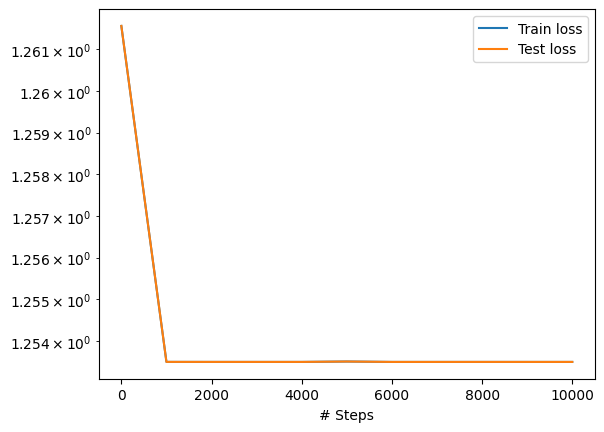

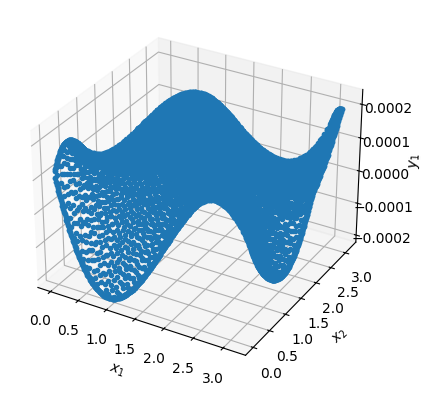

In [10]:
k = 1
m = 1
u_func = lambda x, y: torch.sin(torch.tensor(k * x)) * torch.cos(torch.tensor(m * y))
f, g = generate_poisson_problem(u_func, k, m)
model_1, loss_history_1 = train_pinn(f, g, limits)

In [ ]:
k = 2
m = 3
u_func = lambda x, y: torch.sin(torch.tensor(k * x)) * torch.cos(torch.tensor(m * y))
f, g = generate_poisson_problem(u_func, k, m)
model_2, loss_history_2 = train_pinn(f, g, limits)

Compiling model...
'compile' took 0.000396 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.91e+03, 3.36e-01]    [3.91e+03, 3.36e-01]    []  
500       [1.78e+03, 1.55e+00]    [1.78e+03, 1.55e+00]    []  

Best model at step 500:
  train loss: 1.79e+03
  test loss: 1.79e+03
  test metric: []

'train' took 3.461709 s

Training model...

Step      Train loss              Test loss               Test metric
500       [1.78e+03, 1.55e+00]    [1.78e+03, 1.55e+00]    []  
1000      [8.48e+02, 6.69e+00]    [8.48e+02, 6.69e+00]    []  

Best model at step 1000:
  train loss: 8.54e+02
  test loss: 8.54e+02
  test metric: []

'train' took 3.496791 s

Training model...

Step      Train loss              Test loss               Test metric
1000      [8.48e+02, 6.69e+00]    [8.48e+02, 6.69e+00]    []  
1500      [9.85e+01, 8.42e+00]    [9.85e+01, 8.42e+00]    []  

Best model at step 1500:
  train loss: 1.07e+02
  test loss: 1.07e+02
  test me

C:\Users\Veniamin\AppData\Local\Temp\ipykernel_21296\603324654.py:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Saving loss history to e:\Archive\MSU\Магистратура\КТММ\Task 1\loss.dat ...
Saving training data to e:\Archive\MSU\Магистратура\КТММ\Task 1\train.dat ...
Saving test data to e:\Archive\MSU\Магистратура\КТММ\Task 1\test.dat ...


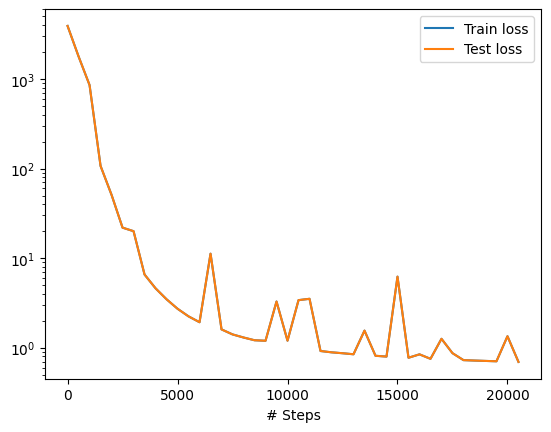

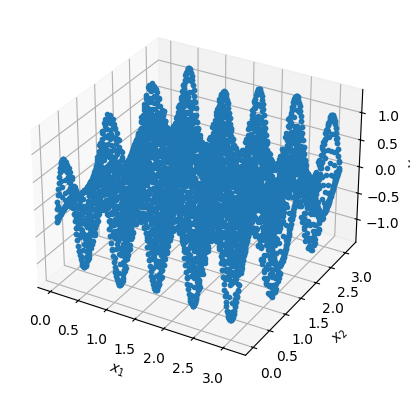

In [8]:
k = 10
m = 5
u_func = lambda x, y: torch.sin(torch.tensor(k * x)) * torch.cos(torch.tensor(m * y))
f, g = generate_poisson_problem(u_func, k, m)
model_3, loss_history_3 = train_pinn(f, g, limits, 20000, 5000, 1000, True)

In [ ]:
# Оценка качества
x_test = np.random.rand(1000, 2) * np.pi
y_exact = u_func(x_test[:, 0:1], x_test[:, 1:2])
y_pred = model_1.predict(x_test)
y_pred = torch.tensor(y_pred, device="cpu").numpy()

l2_abs_error = np.linalg.norm(y_pred - y_exact, 2)
l2_rel_error = l2_abs_error / np.linalg.norm(y_exact, 2)

print(f"Абсолютная L2 ошибка: {l2_abs_error}")
print(f"Относительная L2 ошибка: {l2_rel_error}")

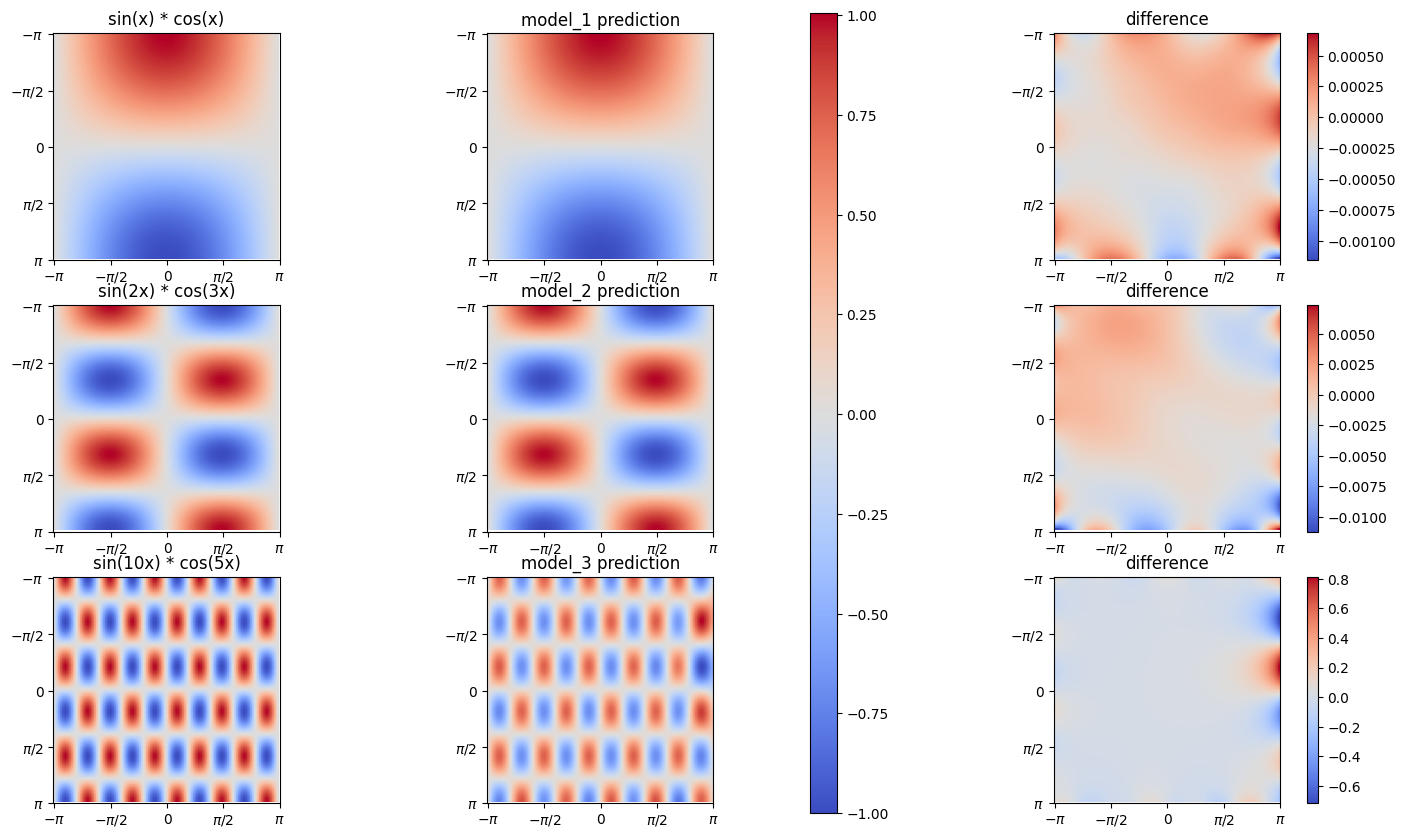

In [35]:
import matplotlib.pyplot as plt

X_partition = 100
Y_partition = 100
left = 0
right = np.pi
a = 1
b = 1
X = np.linspace(left,right,X_partition)
Y = np.linspace(left,right,Y_partition)
x, y = np.meshgrid(X, Y)
grid_points = np.vstack([x.ravel(), y.ravel()]).T 


coef_pairs = [(1, 1), (2, 3), (10, 5)]

z1 = np.sin(1 * x) * np.cos(1 * y)
u1 = model_1.predict(grid_points)
u1 = u1.reshape(X_partition,Y_partition)
dif_1 = z1 - u1

z2 = np.sin(2*x) * np.cos(3*y)
u2 = model_2.predict(grid_points)
u2 = u2.reshape(X_partition,Y_partition)
dif_2 = z2 - u2

z3 = np.sin(10*x) * np.cos(5*y)
u3 = model_3.predict(grid_points)
u3 = u3.reshape(X_partition,Y_partition)
dif_3 = z3 - u3

data_list = [z1, u1, dif_1,
             z2, u2, dif_2,
             z3, u3, dif_3]

ticks_X = np.linspace(0, X_partition, 5)
ticks_Y = np.linspace(0, Y_partition, 5)
tick_labels = [r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"]

fig, axes = plt.subplots(3, 3, figsize=(18, 10), gridspec_kw={'width_ratios': [1, 1, 1.5]})
for i, ax in enumerate(axes.flat):
    im = ax.imshow(data_list[i], cmap="coolwarm", vmin=data_list[i].min(), vmax=data_list[i].max())
    ax.set_title(f'{chr(97 + i)})')
    ax.set_xticks(ticks_X)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(ticks_Y)
    ax.set_yticklabels(tick_labels)
    if(i == 4):
        cbar_ax = fig.add_axes([0.58, 0.1, 0.015, 0.8])
        fig.colorbar(im, cax=cbar_ax)


    if(i%3 == 2):
        fig.colorbar(im, ax=ax) # colorbar для правого столбца

axes[0,0].set_title("sin(x) * cos(x)")
axes[0,1].set_title("model_1 prediction")
axes[0,2].set_title("difference")
axes[1,0].set_title("sin(2x) * cos(3x)")
axes[1,1].set_title("model_2 prediction")
axes[1,2].set_title("difference")
axes[2,0].set_title("sin(10x) * cos(5x)")
axes[2,1].set_title("model_3 prediction")
axes[2,2].set_title("difference")

plt.show()